In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Not used for time series split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [79]:
# Load the dataset, skipping the first row
df = pd.read_csv("ILINet.csv", skiprows=1)
print("--- Initial Data Loaded ---")
print(df.head())
print(df.info())

--- Initial Data Loaded ---
  REGION TYPE REGION  YEAR  WEEK  % WEIGHTED ILI  %UNWEIGHTED ILI  AGE 0-4  \
0    National      X  1997    40         1.10148          1.21686      179   
1    National      X  1997    41         1.20007          1.28064      199   
2    National      X  1997    42         1.37876          1.23906      228   
3    National      X  1997    43         1.19920          1.14473      188   
4    National      X  1997    44         1.65618          1.26112      217   

  AGE 25-49 AGE 25-64  AGE 5-24 AGE 50-64  AGE 65  ILITOTAL  \
0         X       157       205         X      29       570   
1         X       151       242         X      23       615   
2         X       153       266         X      34       681   
3         X       193       236         X      36       653   
4         X       162       280         X      41       700   

   NUM. OF PROVIDERS  TOTAL PATIENTS  
0                192           46842  
1                191           48023  
2      

## Preprocessing

In [81]:
# Initial Cleaning ('X' values)
# Convert problematic columns to numeric (replace 'X' with NaN and fill with median)
# Doing this early before EDA on original ILITOTAL is fine
print("\n--- Cleaning 'X' values ---")
for col in ['AGE 25-49', 'AGE 25-64', 'AGE 50-64']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Impute with 0 or median - using median here as before
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Column {col} cleaned. Median used for NaN: {median_val}")

# Verify dtypes changed
print(df[['AGE 25-49', 'AGE 25-64', 'AGE 50-64']].info())


--- Cleaning 'X' values ---
Column AGE 25-49 cleaned. Median used for NaN: 3264.5
Column AGE 25-64 cleaned. Median used for NaN: 607.0
Column AGE 50-64 cleaned. Median used for NaN: 1359.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1434 entries, 0 to 1433
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AGE 25-49  1434 non-null   float64
 1   AGE 25-64  1434 non-null   float64
 2   AGE 50-64  1434 non-null   float64
dtypes: float64(3)
memory usage: 33.7 KB
None


In [83]:
# Handle Categoricals, plan to use region dummies later
df = pd.get_dummies(df, columns=['REGION TYPE', 'REGION'], drop_first=True)


In [89]:
# Create Datetime Index
print("\n--- Creating Datetime Index ---")
try:
    # Combine YEAR and WEEK, format correctly for pd.to_datetime
    # '%Y%U%w' assumes week starts Sunday (0). Use '%Y%W%w' if Monday (1).
    # Appending '0' for Sunday as the weekday.
    df['date'] = pd.to_datetime(df['YEAR'].astype(str) + df['WEEK'].astype(str).str.zfill(2) + '0', format='%Y%U%w')
    df.set_index('date', inplace=True)
    
    # Attempt to infer frequency - needed for statsmodels
    df.index.freq = pd.infer_freq(df.index)
    print(f"DatetimeIndex created. Inferred frequency: {df.index.freq}")
    if df.index.freq is None:
        print("Warning: Could not infer frequency. SARIMA might require explicit frequency.")

except Exception as e:
    print(f"Error creating DatetimeIndex: {e}")
    print("Proceeding without DatetimeIndex specific operations for EDA")

print(df.head()) # Check the new index


--- Creating Datetime Index ---
DatetimeIndex created. Inferred frequency: None
            YEAR  WEEK  % WEIGHTED ILI  %UNWEIGHTED ILI  AGE 0-4  AGE 25-49  \
date                                                                          
1997-10-05  1997    40         1.10148          1.21686      179     3264.5   
1997-10-12  1997    41         1.20007          1.28064      199     3264.5   
1997-10-19  1997    42         1.37876          1.23906      228     3264.5   
1997-10-26  1997    43         1.19920          1.14473      188     3264.5   
1997-11-02  1997    44         1.65618          1.26112      217     3264.5   

            AGE 25-64  AGE 5-24  AGE 50-64  AGE 65  ILITOTAL  \
date                                                           
1997-10-05      157.0       205     1359.5      29       570   
1997-10-12      151.0       242     1359.5      23       615   
1997-10-19      153.0       266     1359.5      34       681   
1997-10-26      193.0       236     1359.5   

In [91]:
# Keep original ILITOTAL for EDA plots before scaling
df['ILITOTAL_orig'] = df['ILITOTAL'].copy()


--- Performing EDA on Original ILITOTAL Scale ---


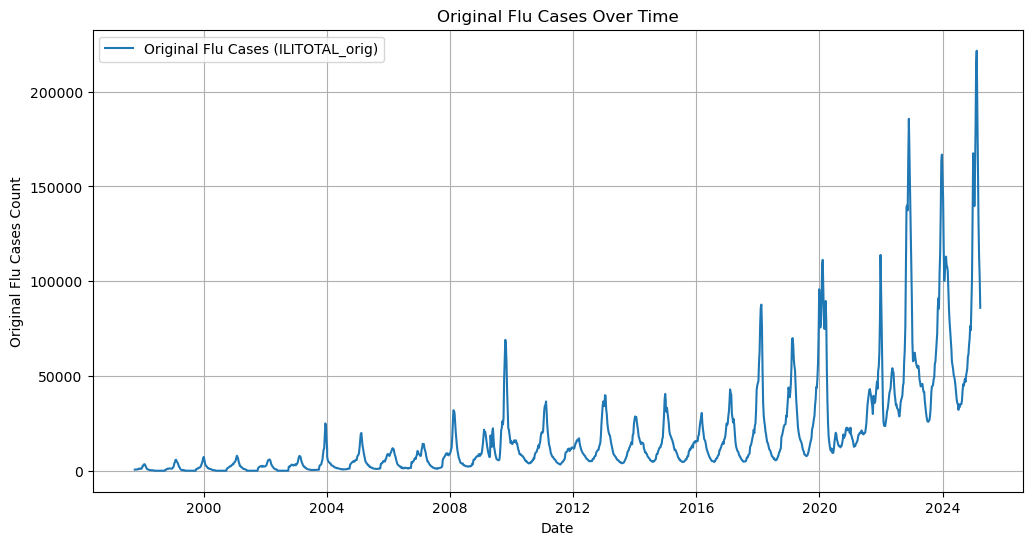

Seasonal Decomposition Results (Original Scale):


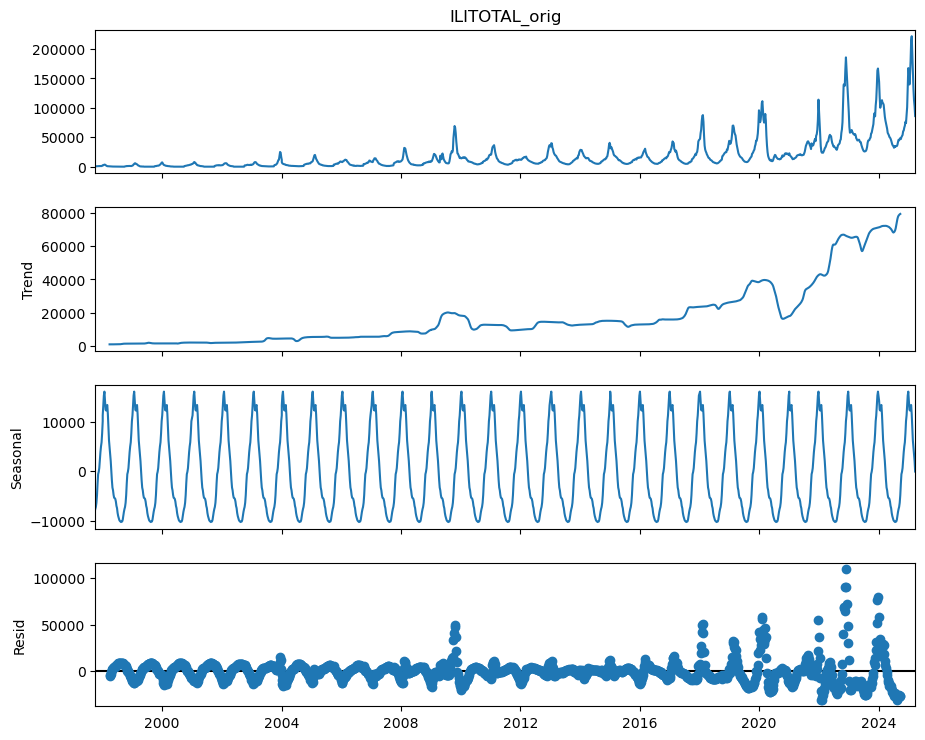

In [93]:
# Exploratory Data Analysis (on Original Scale)

print("\n--- Performing EDA on Original ILITOTAL Scale ---")

# Check if index is DatetimeIndex before plotting
if isinstance(df.index, pd.DatetimeIndex):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['ILITOTAL_orig'], label='Original Flu Cases (ILITOTAL_orig)')
    plt.xlabel('Date')
    plt.ylabel('Original Flu Cases Count')
    plt.title('Original Flu Cases Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Seasonal Decomposition (on original data)
    try:
        decomposition = seasonal_decompose(df['ILITOTAL_orig'], model='additive', period=52) # Assuming weekly data -> 52 week period
        print("Seasonal Decomposition Results (Original Scale):")
        fig = decomposition.plot()
        fig.set_size_inches(10, 8)
        plt.show()
        # Discuss findings based on these plots (trend, seasonality, residuals)
    except Exception as e:
        print(f"Could not perform seasonal decomposition: {e}")
else:
    print("Skipping EDA plots as DatetimeIndex was not successfully created.")



In [95]:
# Scaling Target Variable

print("\n--- Scaling ILITOTAL ---")

scaler = StandardScaler()

# Fit scaler ONLY on ILITOTAL and transform it
df['ILITOTAL_scaled'] = scaler.fit_transform(df[['ILITOTAL']])
print(df[['ILITOTAL', 'ILITOTAL_scaled']].describe())


--- Scaling ILITOTAL ---
            ILITOTAL  ILITOTAL_scaled
count    1434.000000      1434.000000
mean    18456.018131         0.000000
std     27656.893563         1.000349
min         0.000000        -0.667554
25%      2854.750000        -0.564297
50%      8573.000000        -0.357468
75%     20849.000000         0.086554
max    221642.000000         7.349230


In [97]:
# Create Lag Features (from Scaled Data) for LR
print("\n--- Creating Lag Features from Scaled Data ---")
df['lag_1_scaled'] = df['ILITOTAL_scaled'].shift(1)
df['lag_2_scaled'] = df['ILITOTAL_scaled'].shift(2)


--- Creating Lag Features from Scaled Data ---


In [99]:
# Drop NaNs introduced by lag creation

print(f"\nShape before dropping NaNs: {df.shape}")

df.dropna(subset=['lag_1_scaled', 'lag_2_scaled'], inplace=True)
print(f"Shape after dropping NaNs: {df.shape}")


Shape before dropping NaNs: (1434, 17)
Shape after dropping NaNs: (1432, 17)


## Training

In [122]:
# Train-test split chronologically
# Note: standard cross-validation (like K-Fold) isn't suitable for time series
# because it breaks the temporal order
# would need to implement: TimeSeriesSplit (from scikit-learn): This implements a simpler "blocked" CV. 
# It creates folds like this:
# Fold 1: train=[1], test=[2]
# Fold 2: train=[1, 2], test=[3]
# reference: https://scikit-learn.org/stable/modules/cross_validation.html%23time-series-split
# reference: https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split

print("\n--- Performing Train/Test Split ---")

split_ratio = 0.8
split_index = int(len(df) * split_ratio)

# Ensure index is sorted if it's a DatetimeIndex
if isinstance(df.index, pd.DatetimeIndex):
    df = df.sort_index()

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Target variable (scaled)
y_train = train_df['ILITOTAL_scaled']
y_test = test_df['ILITOTAL_scaled']

# Features for Linear Regression (scaled lags)
X_train_lr = train_df[['lag_1_scaled', 'lag_2_scaled']]
X_test_lr = test_df[['lag_1_scaled', 'lag_2_scaled']]

print(f"Train set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Test set dates: {y_test.index.min()} to {y_test.index.max()}")


--- Performing Train/Test Split ---
Train set size: 1145
Test set size: 287
Test set dates: 2019-09-29 00:00:00 to 2025-03-23 00:00:00


## Model Training & Evaluation

In [143]:
# Setting up results object to present needed information from models
results= {}


--- Processing ARIMA Model ---
Fitting ARIMA model on y_train data (using NumPy array)...
ARIMA fitting complete.

--- ARIMA Model Summary (Fitted on Training Data) ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1145
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1480.783
Date:                Fri, 18 Apr 2025   AIC                          -2955.565
Time:                        11:51:52   BIC                          -2940.438
Sample:                             0   HQIC                         -2949.854
                               - 1145                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5755      0.018     32.

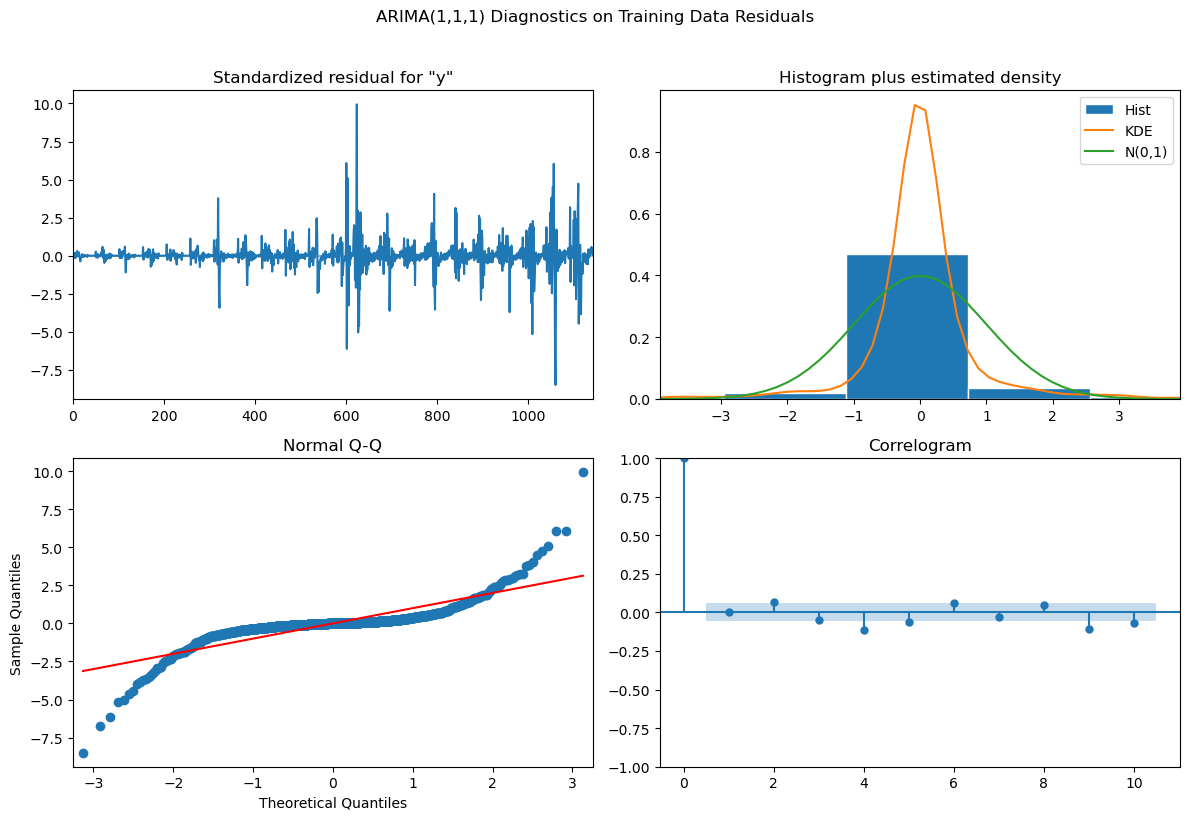


Predicting ARIMA on test set period...
Predicting using integer locations: start=1145, end=1431
Length of y_test: 287
Length of predictions: 287
ARIMA Test RMSE: 1.9941


In [145]:
# == Model 1: ARIMA ==
print("\n--- Processing ARIMA Model ---")
try:
    # --- Define and Fit Model on Training Data (using .values) ---
    print("Fitting ARIMA model on y_train data (using NumPy array)...")

    # Fit on the NumPy array to ignore the pandas index during fitting
    arima_model = ARIMA(y_train.values, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    print("ARIMA fitting complete.")

    # --- Display Training Fit Summary & Diagnostics ---
    # Summary should still work
    print("\n--- ARIMA Model Summary (Fitted on Training Data) ---")
    print(arima_fit.summary())

    # Diagnostics plot might not work well without a time index, wrap in try-except
    try:
        print("\n--- ARIMA Model Diagnostics (Fitted on Training Data) ---")
        fig_diag = arima_fit.plot_diagnostics(figsize=(12, 8))
        plt.suptitle("ARIMA(1,1,1) Diagnostics on Training Data Residuals", y=1.02)
        plt.tight_layout()
        plt.show()
    except Exception as diag_e:
        print(f"Could not plot diagnostics (might require time index): {diag_e}")

    # --- Predict on Test Set Period using INTEGER LOCATIONS ---
    print("\nPredicting ARIMA on test set period...")
    start_loc = len(y_train) # First point AFTER training data
    end_loc = len(y_train) + len(y_test) - 1 # Last point of the test set period
    print(f"Predicting using integer locations: start={start_loc}, end={end_loc}")

    # Prediction using integers should work as the model was fit on an array (no index)
    arima_pred_obj = arima_fit.get_prediction(start=start_loc, end=end_loc)
    # Note: predicted_mean might be a numpy array now
    arima_predictions = arima_pred_obj.predicted_mean

    # --- Calculate and Store RMSE ---
    print(f"Length of y_test: {len(y_test)}")
    print(f"Length of predictions: {len(arima_predictions)}")

    if len(arima_predictions) == len(y_test):
        # Convert prediction numpy array back to a pandas Series with the
        # correct DatetimeIndex from y_test for comparison and plotting.
        arima_predictions_series = pd.Series(arima_predictions, index=y_test.index)

        # Calculate RMSE comparing the original y_test Series and the new prediction Series
        arima_rmse = np.sqrt(mean_squared_error(y_test, arima_predictions_series))
        results['ARIMA'] = arima_rmse # Store result
        print(f"ARIMA Test RMSE: {arima_rmse:.4f}")
    else:
        print(f"ERROR: ARIMA prediction length ({len(arima_predictions)}) mismatch with y_test length ({len(y_test)})")

except Exception as e:
    print(f"Error during ARIMA processing: {e}")




--- Processing SARIMA Model ---
Fitting SARIMA model on y_train data (using NumPy array)...
SARIMA fitting complete.

--- SARIMA Model Summary (Fitted on Training Data) ---
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1145
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                1291.582
Date:                            Fri, 18 Apr 2025   AIC                          -2573.165
Time:                                    11:52:14   BIC                          -2548.439
Sample:                                         0   HQIC                         -2563.784
                                           - 1145                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

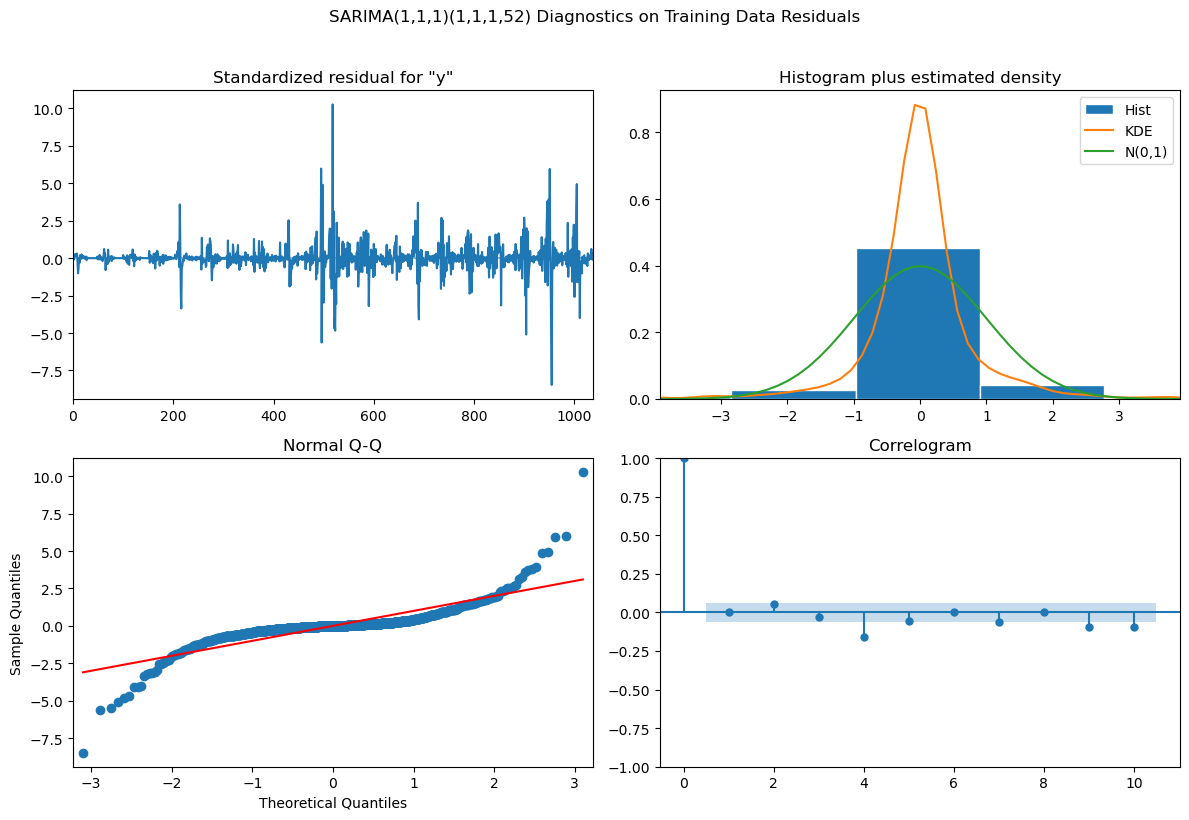


Predicting SARIMA on test set period...
Predicting using integer locations: start=1145, end=1431
Length of y_test: 287
Length of predictions: 287
SARIMA Test RMSE: 1.5414


In [147]:
# Model 2: SARIMA

print("\n--- Processing SARIMA Model ---")

try:
    # --- Define and Fit Model on Training Data (using .values) ---
    print("Fitting SARIMA model on y_train data (using NumPy array)...")

    # Fit on the NumPy array to ignore the pandas index during fitting
    sarima_model = SARIMAX(y_train.values, # Use .values here
                           order=(1, 1, 1),
                           seasonal_order=(1, 1, 1, 52), # P, D, Q, S
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_fit = sarima_model.fit(disp=False) # Suppress convergence output
    print("SARIMA fitting complete.")

    # --- Display Training Fit Summary & Diagnostics ---
    print("\n--- SARIMA Model Summary (Fitted on Training Data) ---")
    print(sarima_fit.summary())

    # Diagnostics plot might not work well without a time index
    try:
        print("\n--- SARIMA Model Diagnostics (Fitted on Training Data) ---")
        fig_diag = sarima_fit.plot_diagnostics(figsize=(12, 8))
        plt.suptitle("SARIMA(1,1,1)(1,1,1,52) Diagnostics on Training Data Residuals", y=1.02)
        plt.tight_layout()
        plt.show()
    except Exception as diag_e:
        print(f"Could not plot diagnostics (might require time index): {diag_e}")

    # --- Predict on Test Set Period using INTEGER LOCATIONS ---
    print("\nPredicting SARIMA on test set period...")
    start_loc = len(y_train) # First point AFTER training data
    end_loc = len(y_train) + len(y_test) - 1 # Last point of the test set period
    print(f"Predicting using integer locations: start={start_loc}, end={end_loc}")

    # Prediction using integers
    sarima_pred_obj = sarima_fit.get_prediction(start=start_loc, end=end_loc)
    # Note: predicted_mean might be a numpy array now
    sarima_predictions = sarima_pred_obj.predicted_mean

    # --- Calculate and Store RMSE ---
    print(f"Length of y_test: {len(y_test)}")
    print(f"Length of predictions: {len(sarima_predictions)}")

    if len(sarima_predictions) == len(y_test):
        # Convert prediction numpy array back to a pandas Series with the
        # correct DatetimeIndex from y_test for comparison and plotting.
        sarima_predictions_series = pd.Series(sarima_predictions, index=y_test.index)

        # Calculate RMSE comparing the original y_test Series and the new prediction Series
        sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_predictions_series))
        results['SARIMA'] = sarima_rmse # Store result
        print(f"SARIMA Test RMSE: {sarima_rmse:.4f}")
    else:
        print(f"ERROR: SARIMA prediction length ({len(sarima_predictions)}) mismatch with y_test length ({len(y_test)})")

except Exception as e:
    print(f"Error during SARIMA processing: {e}")

In [148]:
# Model 3: Linear Regression

print("\n--- Training Linear Regression Model ---")
try:
    lr_model = LinearRegression()
    # Fit using pandas DataFrame (X_train_lr) and Series (y_train)
    lr_model.fit(X_train_lr, y_train)
    print("Linear Regression fitting complete.")

    print("Predicting Linear Regression on test set...")
    # Predict using pandas DataFrame (X_test_lr) -> returns NumPy array
    lr_predictions = lr_model.predict(X_test_lr)

    # Convert NumPy array output to pandas Series with y_test index for comparison/plotting
    lr_predictions_series = pd.Series(lr_predictions, index=y_test.index)

    # Calculate RMSE comparing y_test Series and the prediction Series
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions_series))
    results['Linear Regression'] = lr_rmse
    print(f"Linear Regression Test RMSE: {lr_rmse:.4f}")

except Exception as e:
    print(f"Error during Linear Regression processing: {e}")


--- Training Linear Regression Model ---
Linear Regression fitting complete.
Predicting Linear Regression on test set...
Linear Regression Test RMSE: 0.2858


In [149]:
# Print the entire results dictionary
print("\n--- Collected RMSE Results ---")
print(results)


--- Collected RMSE Results ---
{'ARIMA': 1.9940943822242472, 'SARIMA': 1.5414417497902408, 'Linear Regression': 0.2857533782050547}


In [153]:
# --- 11. Results Summary ---
print("\n--- Model Comparison (Test RMSE on Scaled Data) ---")
best_model_name = None
lowest_rmse = float('inf')
for model_name, rmse_value in results.items():
    print(f"{model_name}: {rmse_value:.4f}")
    if rmse_value < lowest_rmse:
        lowest_rmse = rmse_value
        best_model_name = model_name
print(f"\nBest performing model based on Test RMSE: {best_model_name} (RMSE: {lowest_rmse:.4f})")



--- Model Comparison (Test RMSE on Scaled Data) ---
ARIMA: 1.9941
SARIMA: 1.5414
Linear Regression: 0.2858

Best performing model based on Test RMSE: Linear Regression (RMSE: 0.2858)


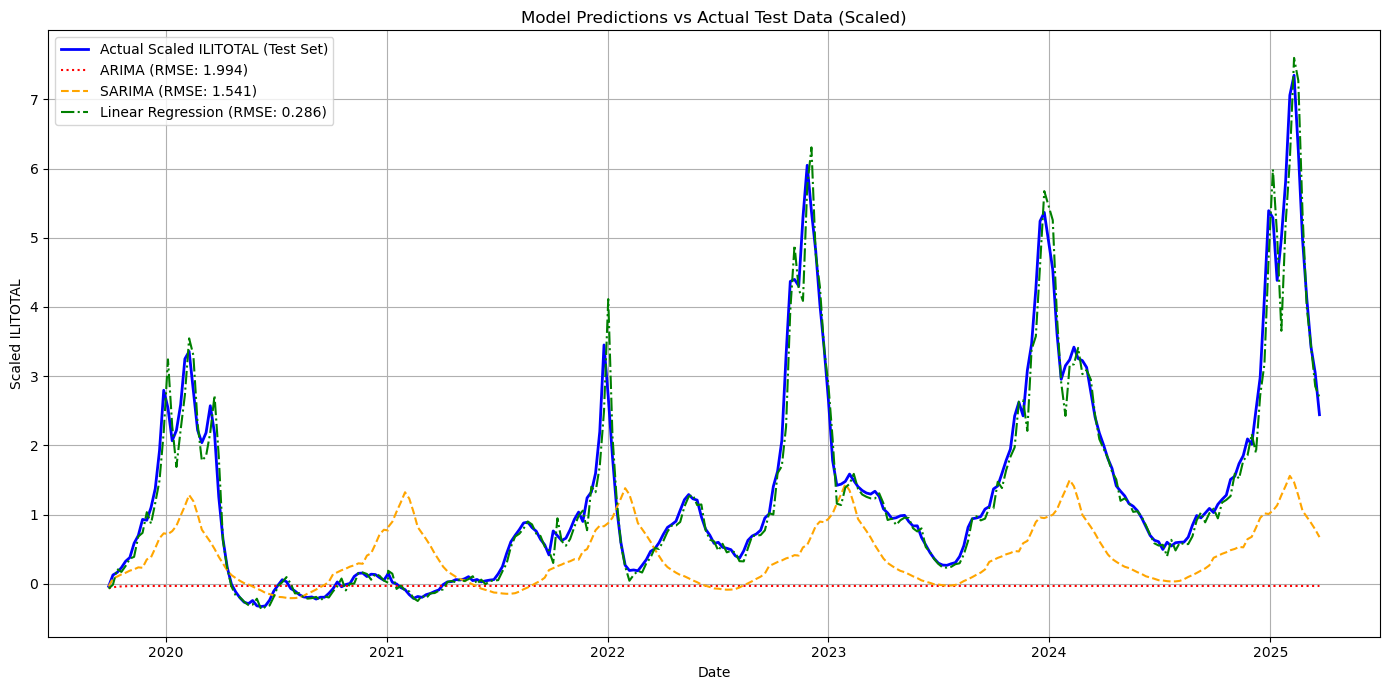

In [155]:
# Plot predictions vs Actual on TEST SET

# This plot compares how each model performed on the historical test data
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Scaled ILITOTAL (Test Set)', color='blue', linewidth=2)
# Add predictions if they exist in the results dictionary
if 'ARIMA' in results and 'arima_predictions_series' in locals(): # Check if prediction exists
    plt.plot(arima_predictions_series.index, arima_predictions_series, label=f'ARIMA (RMSE: {results["ARIMA"]:.3f})', color='red', linestyle=':')
if 'SARIMA' in results and 'sarima_predictions_series' in locals(): # Check if prediction exists
    plt.plot(sarima_predictions_series.index, sarima_predictions_series, label=f'SARIMA (RMSE: {results["SARIMA"]:.3f})', color='orange', linestyle='--')
if 'SARIMAX' in results and 'sarimax_predictions_series' in locals(): # Check if prediction exists
     plt.plot(sarimax_predictions_series.index, sarimax_predictions_series, label=f'SARIMAX (RMSE: {results["SARIMAX"]:.3f})', color='purple', linestyle='--')
if 'Linear Regression' in results and 'lr_predictions_series' in locals(): # Check if prediction exists
    plt.plot(lr_predictions_series.index, lr_predictions_series, label=f'Linear Regression (RMSE: {results["Linear Regression"]:.3f})', color='green', linestyle='-.')

plt.title('Model Predictions vs Actual Test Data (Scaled)')
plt.xlabel('Date')
plt.ylabel('Scaled ILITOTAL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [159]:
# Re-fit Best Model on Full Data & Forecast Future
print(f"\n--- Re-fitting {best_model_name} on Full Data and Forecasting Future ---")

# Define the full dataset before the split, after lags/NaN drop
# Ensure 'df' is the final processed DataFrame from Step 8
y_full = df['ILITOTAL_scaled']        # Full history of scaled target
X_full_lr = df[['lag_1_scaled', 'lag_2_scaled']] # Full history of scaled lag features

# How many weeks into the future to predict?
forecast_steps = 52 # e.g., 1 year

# Variables to store results
final_forecast_values = None
final_conf_int = None # LR iterative forecast doesn't easily give CIs
final_model_fit = None

try:
    # --- Re-train the Linear Regression model ---
    print(f"Re-training Linear Regression on all available data (length: {len(y_full)})...")
    final_lr_model = LinearRegression()
    # Fit using all historical scaled lags and the corresponding scaled target
    final_lr_model.fit(X_full_lr, y_full)
    final_model_fit = final_lr_model # Store the finally trained model object
    print("Re-training complete.")

    # Generate Future Forecast (Iteratively)
    # Since the prediction for week W+1 depends on values from week W and W-1,
    # and the prediction for week W+2 depends on the *prediction* for W+1,
    # we need to predict one step at a time in a loop.

    print(f"Generating {forecast_steps}-step future forecast (iteratively)...")

    # Get the last actual values needed to start the forecast loop
    # Need the last two scaled ILITOTAL values from our historical data
    last_known_y = y_full.values[-2:] # NumPy array makes updating easier

    # List to collect the predictions as we generate them
    future_preds_list = []

    # Loop for each future step to predict
    for step in range(forecast_steps):
        # The input features for the model are [lag1, lag2]
        # For the next prediction, lag1 is the *last* value in history,
        # and lag2 is the *second to last* value.
        current_lags_for_prediction = np.array([last_known_y[-1], last_known_y[-2]]).reshape(1, -1)

        # Use the final trained LR model to predict the single next value
        next_prediction = final_lr_model.predict(current_lags_for_prediction)[0]

        # Add this prediction to our list
        future_preds_list.append(next_prediction)

        # Update history
        # The prediction just made becomes the new "last known value" for the *next* loop iteration.
        # Append the prediction and drop the oldest value to keep the history size correct.
        last_known_y = np.append(last_known_y, next_prediction)[1:]

    # --- Create Future Dates and Final Forecast Series ---
    # Now there is a list of forecast values, let's give them future dates

    last_date_in_data = df.index[-1] # The last date from historical data
    # Create weekly dates starting from the week after the last known date
    future_index = pd.date_range(
        start=last_date_in_data + pd.Timedelta(weeks=1),
        periods=forecast_steps,
        freq=df.index.freq # Use the same frequency as the original data
    )

    # Convert the list of predictions into a pandas Series with the future dates
    final_forecast_values = pd.Series(future_preds_list, index=future_index)

    # Confidence intervals are not easily calculated for this iterative LR process
    final_conf_int = None
    print("Future forecast generated.")

except Exception as e:
    print(f"Error during final Linear Regression fitting/forecasting: {e}")


--- Re-fitting Linear Regression on Full Data and Forecasting Future ---
Re-training Linear Regression on all available data (length: 1432)...
Re-training complete.
Generating 52-step future forecast (iteratively)...
Future forecast generated.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/p


--- Plotting Future Forecast ---


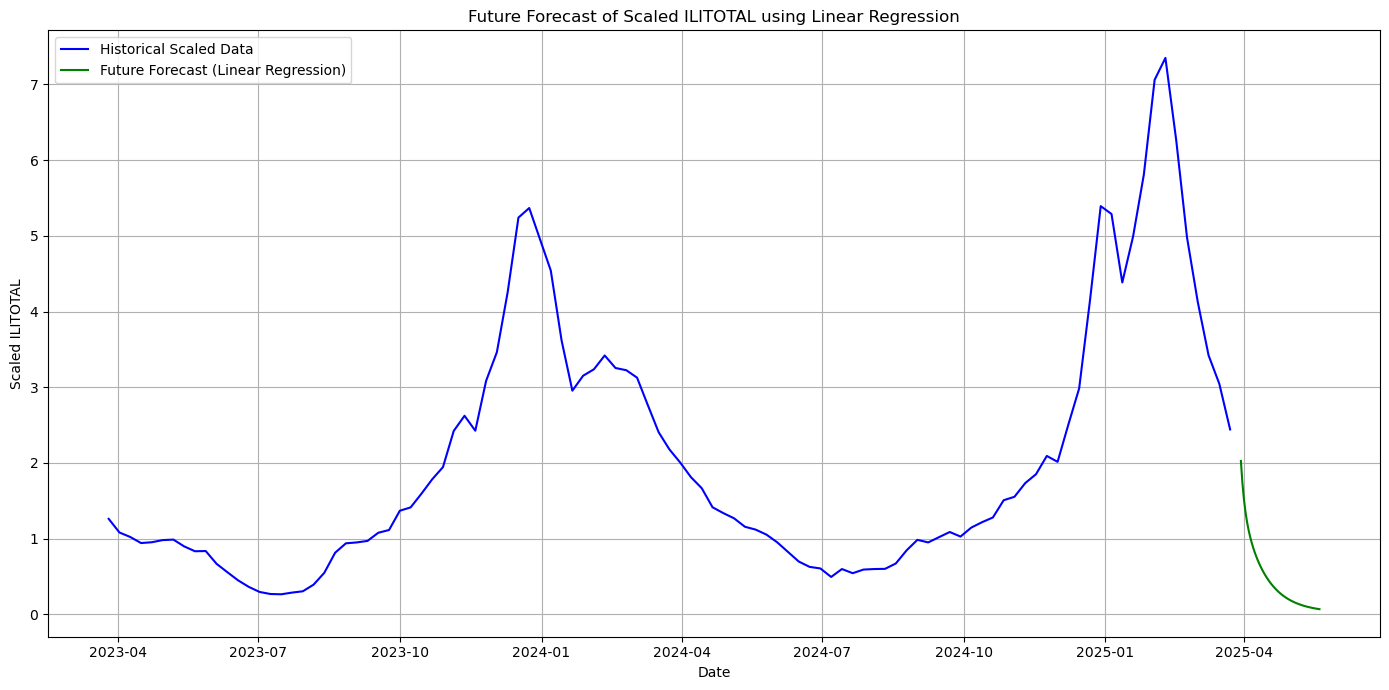

In [161]:
# LR Plotting
# These steps use the 'final_forecast_values' above

if final_forecast_values is not None:
    print("\n--- Plotting Future Forecast ---")
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[-104:], df['ILITOTAL_scaled'].iloc[-104:], label='Historical Scaled Data', color='blue')
    plt.plot(final_forecast_values.index, final_forecast_values, label='Future Forecast (Linear Regression)', color='green')
    # No confidence interval to plot here usually
    plt.title('Future Forecast of Scaled ILITOTAL using Linear Regression')
    plt.xlabel('Date')
    plt.ylabel('Scaled ILITOTAL')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
     print("\nNo future forecast was generated.")


--- Plotting Future Forecast (SARIMA) ---
Confidence interval data (for SARIMA) not found for plotting.


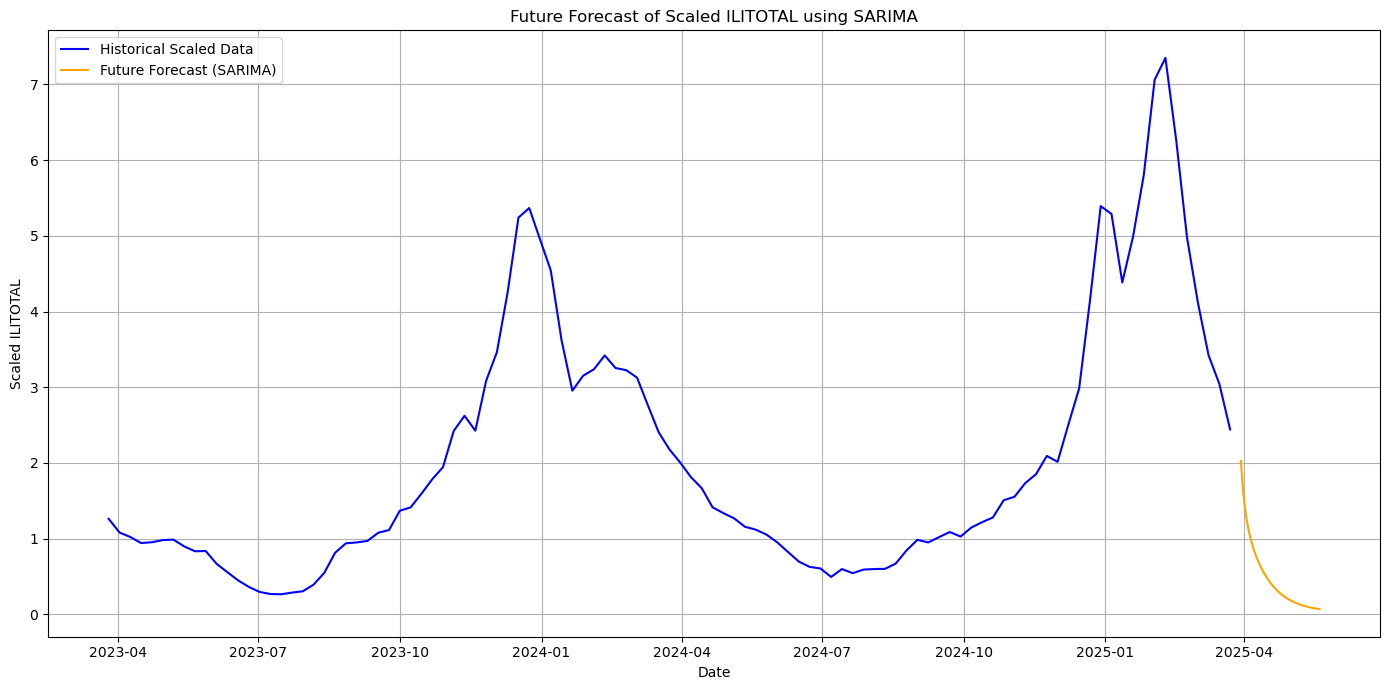

In [165]:
# SARIMA Forecast

print("\n--- Plotting Future Forecast (SARIMA) ---")

if 'final_forecast_values' in locals() and final_forecast_values is not None:
    plt.figure(figsize=(14, 7))

    # Plot recent historical data
    plt.plot(df.index[-104:], df['ILITOTAL_scaled'].iloc[-104:], label='Historical Scaled Data', color='blue')

    # Plot the SARIMA mean forecast
    plt.plot(final_forecast_values.index, final_forecast_values, label='Future Forecast (SARIMA)', color='orange') # Color changed for distinction

    # Plot the SARIMA confidence intervals
    if 'final_conf_int' in locals() and final_conf_int is not None:
        plt.fill_between(final_conf_int.index,
                         final_conf_int.iloc[:, 0], # lower CI bound
                         final_conf_int.iloc[:, 1], # upper CI bound
                         color='peachpuff', alpha=0.5, label='95% Confidence Interval') # Different color/alpha
    else:
        print("Confidence interval data (for SARIMA) not found for plotting.")

    # Formatting
    plt.title('Future Forecast of Scaled ILITOTAL using SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Scaled ILITOTAL')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nSARIMA forecast data ('final_forecast_values') not found.")



--- Plotting Future Forecast (SARIMAX) ---
Confidence interval data (for SARIMAX) not found for plotting.


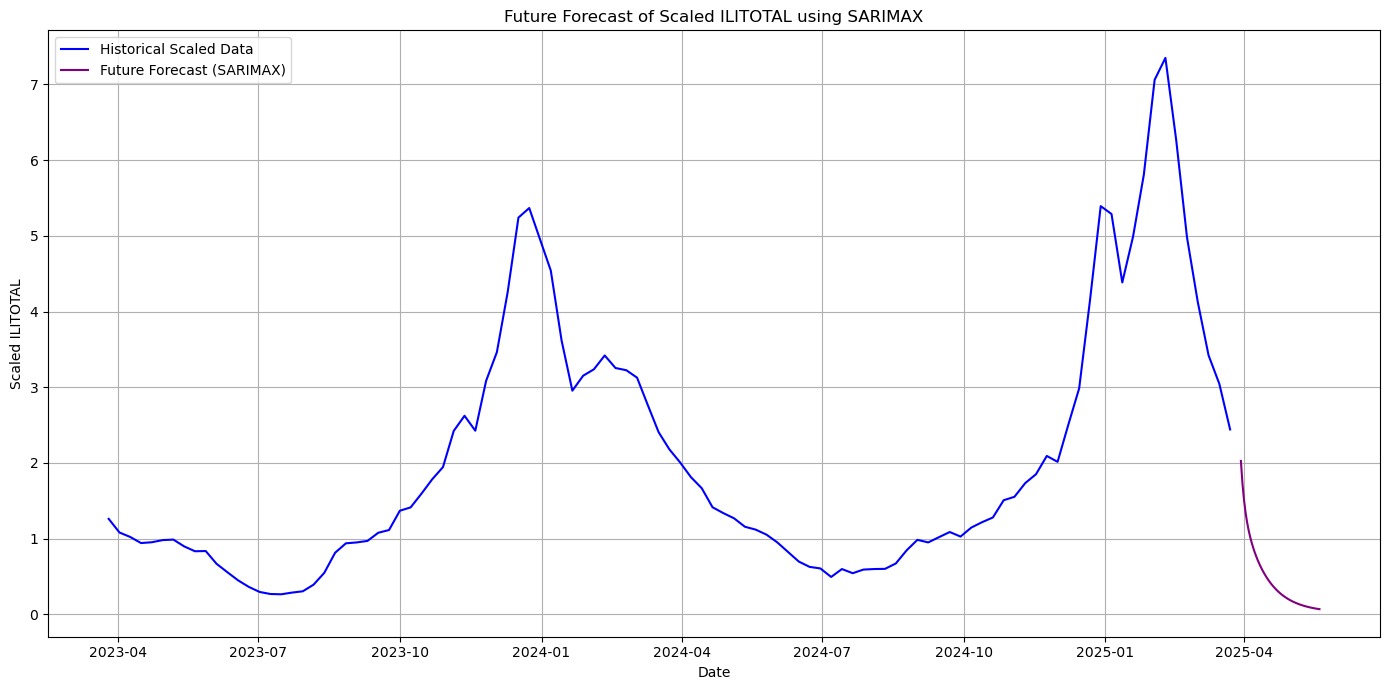

In [167]:
# SARIMAX Forecast

print("\n--- Plotting Future Forecast (SARIMAX) ---")

if 'final_forecast_values' in locals() and final_forecast_values is not None:
    plt.figure(figsize=(14, 7))

    # Plot recent historical data
    plt.plot(df.index[-104:], df['ILITOTAL_scaled'].iloc[-104:], label='Historical Scaled Data', color='blue')

    # Plot the SARIMAX mean forecast
    plt.plot(final_forecast_values.index, final_forecast_values, label='Future Forecast (SARIMAX)', color='purple') # Color changed

    # Plot the SARIMAX confidence intervals
    if 'final_conf_int' in locals() and final_conf_int is not None:
        plt.fill_between(final_conf_int.index,
                         final_conf_int.iloc[:, 0], # lower CI bound
                         final_conf_int.iloc[:, 1], # upper CI bound
                         color='thistle', alpha=0.5, label='95% Confidence Interval') # Different color/alpha
    else:
        print("Confidence interval data (for SARIMAX) not found for plotting.")

    # Formatting
    plt.title('Future Forecast of Scaled ILITOTAL using SARIMAX')
    plt.xlabel('Date')
    plt.ylabel('Scaled ILITOTAL')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nSARIMAX forecast data ('final_forecast_values') not found.")


--- Plotting Combined Future Forecasts ---


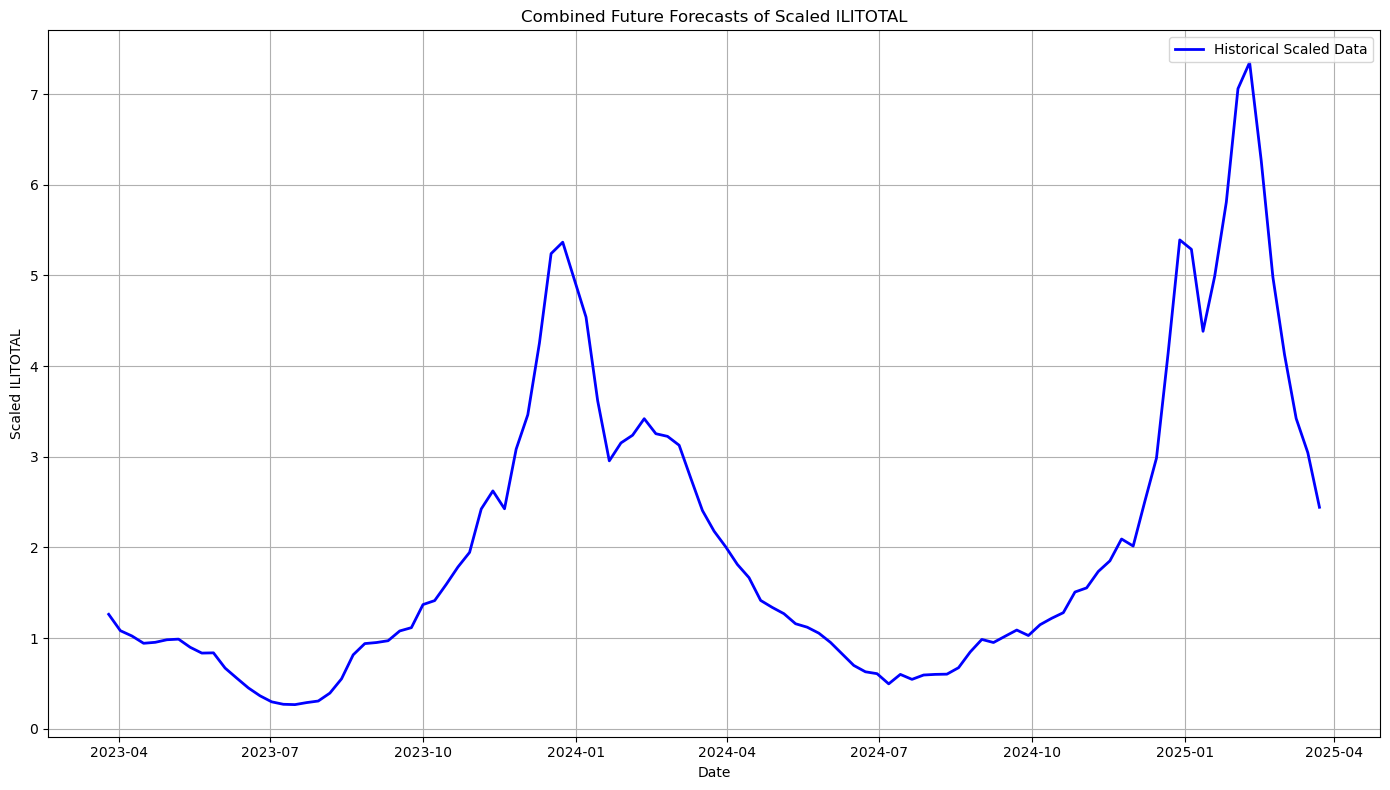

In [173]:

print("\n--- Plotting Combined Future Forecasts ---")
plt.figure(figsize=(14, 8)) # Slightly larger figure
plt.plot(df.index[-104:], df['ILITOTAL_scaled'].iloc[-104:], label='Historical Scaled Data', color='blue', linewidth=2)
if 'lr_final_forecast_values' in locals() and lr_final_forecast_values is not None:
    plt.plot(lr_final_forecast_values.index, lr_final_forecast_values, label='Forecast (Linear Regression)', color='green', linestyle='-.')

if 'sarima_final_forecast_values' in locals() and sarima_final_forecast_values is not None:
    plt.plot(sarima_final_forecast_values.index, sarima_final_forecast_values, label='Forecast (SARIMA)', color='orange', linestyle='--')

if 'sarimax_final_forecast_values' in locals() and sarimax_final_forecast_values is not None:
    plt.plot(sarimax_final_forecast_values.index, sarimax_final_forecast_values, label='Forecast (SARIMAX)', color='purple', linestyle=':')
    
plt.title('Combined Future Forecasts of Scaled ILITOTAL')
plt.xlabel('Date')
plt.ylabel('Scaled ILITOTAL')
# Ensure legend doesn't get too crowded if CIs are plotted
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()